# Synthetic Linear Regression In-Context Learning with a Transformer

This notebook generates a **synthetic multi-task linear regression dataset** and trains a
**numeric Transformer** to perform **in-context learning (ICL)**.

For each *task*:
- Sample a slope `a` and intercept `b`.
- Sample several context points `(x_i, y_i)` from `y = a x + b + noise`.
- Sample one query point `(x_q, y_q)` from the *same* line.

The Transformer sees a sequence of tokens of the form:
- Demo tokens: `[x_i, y_i, is_demo=1.0, is_query=0.0]`
- Query token: `[x_q, 0.0, 0.0, 1.0]`

At **evaluation time**, we vary the number of demonstrations `k` (0-, 1-, 3-, 5-, 8-shot)
and measure **RMSE vs k**. You should see RMSE **decrease as k increases**, which is the
classic ICL behavior for linear regression.


In [1]:
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

print('PyTorch version:', torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

PyTorch version: 2.9.1+cu128
Using device: cuda


Train tasks: 20000
Test tasks: 4000


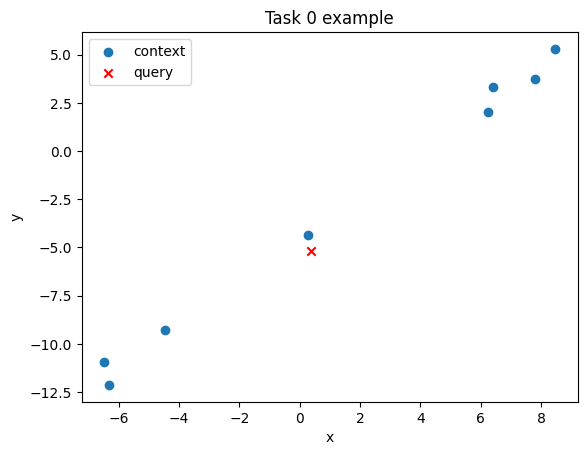

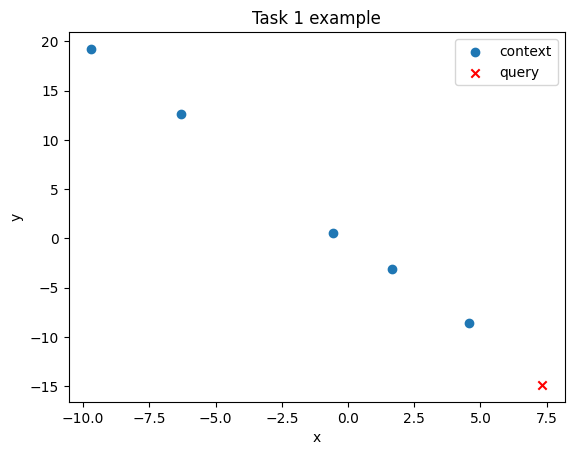

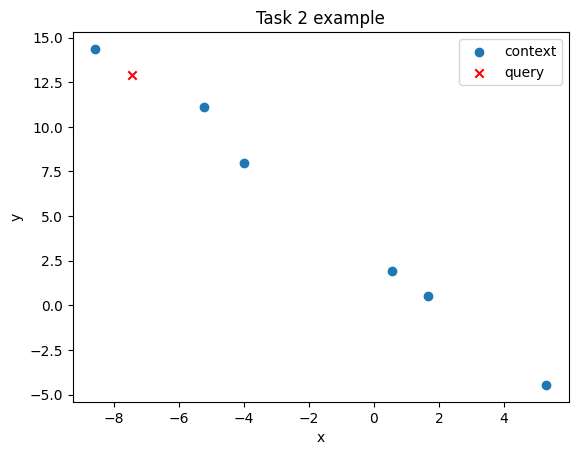

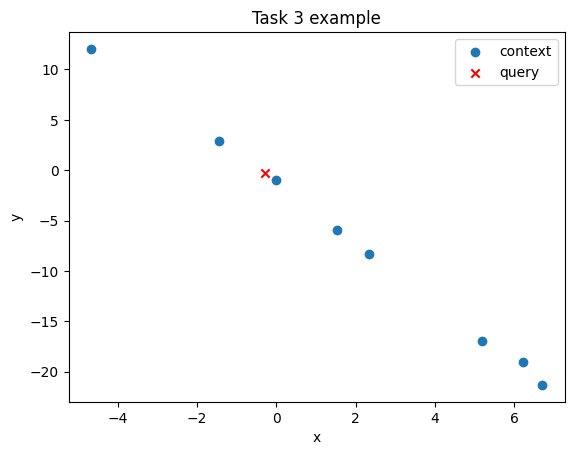

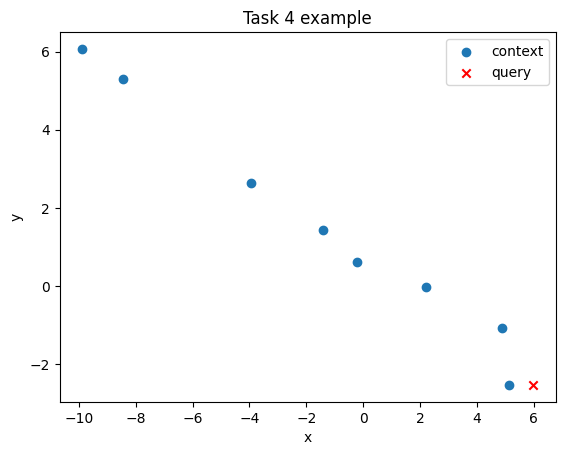

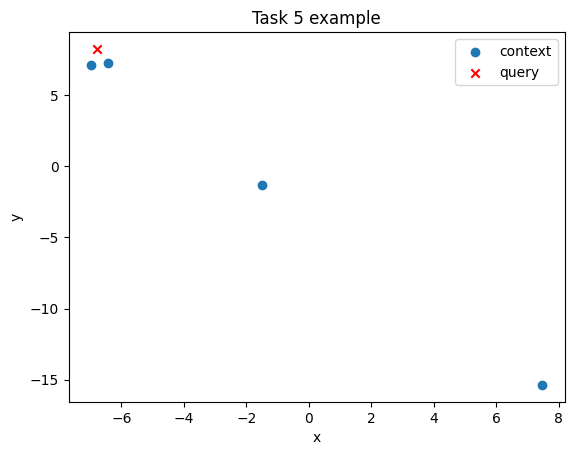

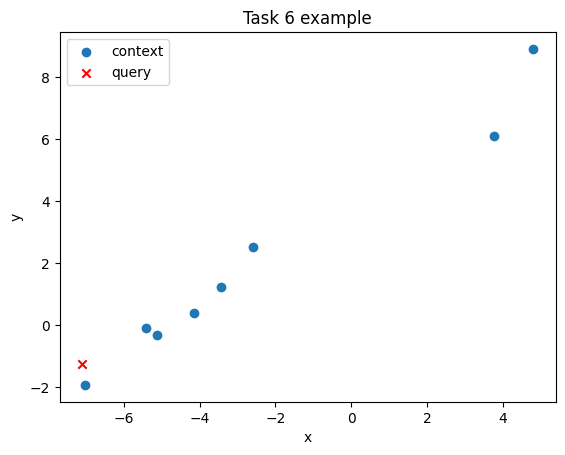

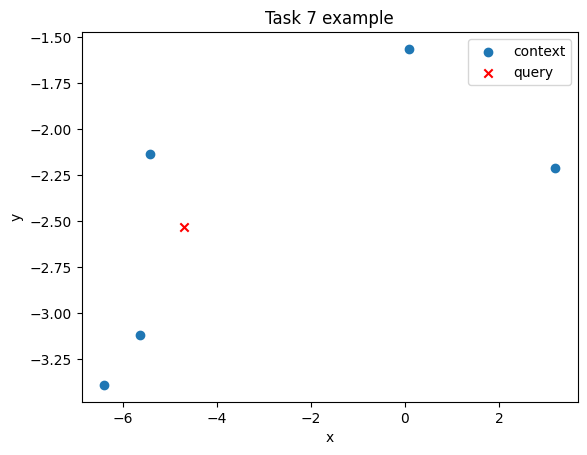

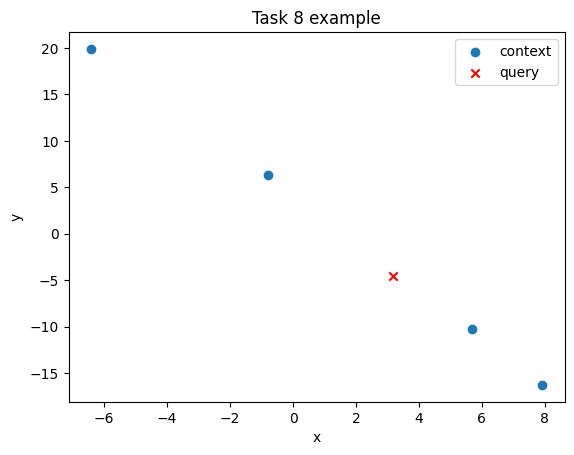

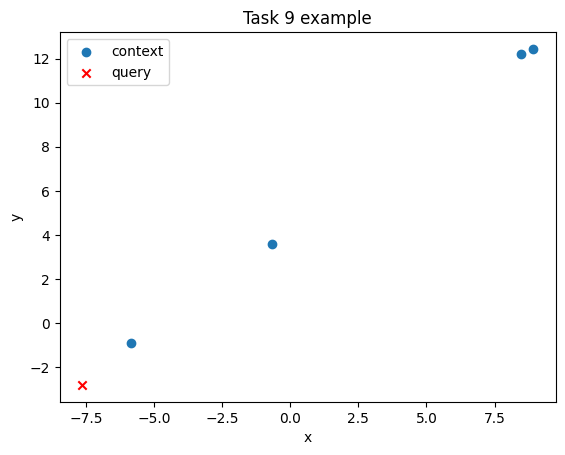

In [2]:
@dataclass
class LinearTask:
    xs: np.ndarray   # shape (K,)
    ys: np.ndarray   # shape (K,)
    xq: float
    yq: float

def generate_linear_tasks(
    n_tasks: int,
    k_min: int = 4,
    k_max: int = 8,
    x_range = (-10.0, 10.0),
    slope_range = (-3.0, 3.0),
    intercept_range = (-5.0, 5.0),
    noise_std: float = 0.5,
    seed: int = 42,
):
    """Generate a list of multi-shot linear regression tasks.

    Each task has its own slope and intercept:
      y = a x + b + eps, eps ~ N(0, noise_std^2)
    """
    rng = np.random.default_rng(seed)
    tasks = []
    for _ in range(n_tasks):
        a = rng.uniform(*slope_range)
        b = rng.uniform(*intercept_range)
        K = rng.integers(k_min, k_max + 1)

        xs = rng.uniform(*x_range, size=K)
        noise = rng.normal(0.0, noise_std, size=K)
        ys = a * xs + b + noise

        # query point
        xq = rng.uniform(*x_range)
        yq = a * xq + b + rng.normal(0.0, noise_std)

        tasks.append(LinearTask(xs=xs, ys=ys, xq=float(xq), yq=float(yq)))
    return tasks


# Generate synthetic tasks
N_TRAIN_TASKS = 20000
N_TEST_TASKS  = 4000

train_tasks = generate_linear_tasks(N_TRAIN_TASKS, seed=123)
test_tasks  = generate_linear_tasks(N_TEST_TASKS,  seed=456)

print('Train tasks:', len(train_tasks))
print('Test tasks:', len(test_tasks))

# Visual sanity check on a few tasks
for i in range(10):
    t = train_tasks[i]
    plt.figure()
    plt.scatter(t.xs, t.ys, label='context')
    plt.scatter([t.xq], [t.yq], marker='x', c='red', label='query')
    plt.title(f'Task {i} example')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [3]:
class LinearTaskDataset(Dataset):
    def __init__(self, tasks):
        self.tasks = tasks

    def __len__(self):
        return len(self.tasks)

    def __getitem__(self, idx):
        t = self.tasks[idx]
        return (
            torch.tensor(t.xs, dtype=torch.float32),
            torch.tensor(t.ys, dtype=torch.float32),
            torch.tensor(t.xq, dtype=torch.float32),
            torch.tensor(t.yq, dtype=torch.float32),
        )


train_dataset = LinearTaskDataset(train_tasks)
test_dataset  = LinearTaskDataset(test_tasks)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

Train dataset size: 20000
Test dataset size: 4000


In [4]:
def build_icl_tokens(pairs, x_query):
    """Build numeric tokens for ICL.

    pairs: list of (x_i, y_i) demos
    x_query: scalar

    Demo tokens: [x_i, y_i, 1.0, 0.0]
    Query token: [x_query, 0.0, 0.0, 1.0]
    Returns (T, 4)
    """
    tokens = []
    for x, y in pairs:
        tokens.append([float(x), float(y), 1.0, 0.0])
    tokens.append([float(x_query), 0.0, 0.0, 1.0])
    return torch.tensor(tokens, dtype=torch.float32)


In [5]:
def make_collate_fn(k_min=1, k_max=8):
    def collate(batch):
        token_seqs = []
        lengths = []
        ys_out = []

        for xs, ys, xq, yq in batch:
            xs = xs.numpy()
            ys = ys.numpy()
            xq = float(xq.item())
            yq = float(yq.item())
            K_total = xs.shape[0]
            if K_total == 0:
                continue

            k_hi = min(k_max, K_total)
            k_lo = min(k_min, k_hi)
            k = random.randint(k_lo, k_hi)

            idxs = random.sample(range(K_total), k)
            pairs = [(xs[i], ys[i]) for i in idxs]

            tokens = build_icl_tokens(pairs, xq)
            token_seqs.append(tokens)
            lengths.append(tokens.size(0))
            ys_out.append(yq)

        B = len(token_seqs)
        if B == 0:
            return torch.empty(0, 1, 4), torch.empty(0, dtype=torch.long), torch.empty(0)

        T_max = max(lengths)
        x_padded = torch.zeros(B, T_max, 4, dtype=torch.float32)
        for i, tok in enumerate(token_seqs):
            T = tok.size(0)
            x_padded[i, :T, :] = tok

        lengths = torch.tensor(lengths, dtype=torch.long)
        ys_out = torch.tensor(ys_out, dtype=torch.float32)
        return x_padded, lengths, ys_out

    return collate

BATCH_SIZE = 64
train_collate = make_collate_fn(k_min=1, k_max=8)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_collate)

# Inspect one batch
x_dbg, len_dbg, y_dbg = next(iter(train_loader))
print('Batch x shape:', x_dbg.shape)
print('Batch lengths:', len_dbg.shape)
print('Batch y shape:', y_dbg.shape)

Batch x shape: torch.Size([64, 8, 4])
Batch lengths: torch.Size([64])
Batch y shape: torch.Size([64])


In [6]:
class NumericTransformerICL(nn.Module):
    def __init__(
        self,
        input_dim=4,
        d_model=128,
        n_heads=4,
        n_layers=4,
        max_len=16,
        dropout=0.1,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.max_len = max_len

        self.value_proj = nn.Linear(input_dim, d_model)
        self.pos_embed  = nn.Embedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.reg_head = nn.Linear(d_model, 1)

    def forward(self, x, lengths):
        B, T, D_in = x.shape
        device = x.device
        if T > self.max_len:
            raise ValueError(
                f'Sequence length T={T} exceeds max_len={self.max_len}. '
                'Increase max_len in the model.'
            )

        h = self.value_proj(x)  # (B, T, d_model)
        pos_ids = torch.arange(T, device=device)[None, :]
        pos = self.pos_embed(pos_ids)
        h = h + pos

        idxs = torch.arange(T, device=device)[None, :].expand(B, T)
        pad_mask = idxs >= lengths.unsqueeze(1)

        h_enc = self.encoder(h, src_key_padding_mask=pad_mask)

        last_idx = (lengths - 1).clamp(min=0)
        batch_idx = torch.arange(B, device=device)
        h_last = h_enc[batch_idx, last_idx, :]

        y_pred = self.reg_head(h_last).squeeze(-1)
        return y_pred


In [7]:
K_MAX_TOKENS = 8 + 1  # 8 demos + 1 query
model = NumericTransformerICL(
    input_dim=4,
    d_model=128,
    n_heads=4,
    n_layers=4,
    max_len=K_MAX_TOKENS + 2,
    dropout=0.1,
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print('Total parameters:', total_params)

Total parameters: 795265


In [8]:
def train_model(model, train_loader, epochs=5, lr=1e-4, device='cuda'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_mse = 0.0
        total_count = 0
        pbar = tqdm(train_loader)
        for x, lengths, y in pbar:
            if x.size(0) == 0:
                continue
            x = x.to(device)
            lengths = lengths.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            preds = model(x, lengths)
            mse = criterion(preds, y)
            mse.backward()
            optimizer.step()

            bs = x.size(0)
            total_mse += mse.item() * bs
            total_count += bs
            pbar.set_postfix(mse=mse.item(), rmse=mse.item() ** 0.5)

        avg_mse = total_mse / max(total_count, 1)
        avg_rmse = avg_mse ** 0.5
        print(f'Epoch {epoch+1}/{epochs} - Train MSE: {avg_mse:.4f}, RMSE: {avg_rmse:.4f}')

    return model


In [9]:
EPOCHS = 5
LR = 1e-4

model = train_model(model, train_loader, epochs=EPOCHS, lr=LR, device=device)

100%|███████████████████| 313/313 [00:02<00:00, 123.37it/s, mse=24.2, rmse=4.92]


Epoch 1/5 - Train MSE: 47.7118, RMSE: 6.9074


100%|███████████████████| 313/313 [00:02<00:00, 140.61it/s, mse=25.9, rmse=5.09]


Epoch 2/5 - Train MSE: 26.0018, RMSE: 5.0992


100%|███████████████████| 313/313 [00:02<00:00, 140.48it/s, mse=12.2, rmse=3.49]


Epoch 3/5 - Train MSE: 19.3674, RMSE: 4.4008


100%|███████████████████| 313/313 [00:02<00:00, 155.48it/s, mse=19.2, rmse=4.38]


Epoch 4/5 - Train MSE: 15.7365, RMSE: 3.9669


100%|███████████████████| 313/313 [00:02<00:00, 141.12it/s, mse=10.5, rmse=3.24]

Epoch 5/5 - Train MSE: 13.5744, RMSE: 3.6843


In [11]:
def run_icl_eval(model, tasks, k_list=(0, 1, 3, 5, 8), num_samples=1000, device='cuda'):
    model.eval()
    results = {}

    with torch.no_grad():
        for k in k_list:
            sq_errors = []
            used = 0
            for _ in range(num_samples):
                t = random.choice(tasks)
                xs = t.xs
                ys = t.ys
                xq = t.xq
                yq = t.yq

                K_total = xs.shape[0]
                if k > K_total:
                    continue

                if k == 0:
                    pairs = []
                else:
                    idxs = random.sample(range(K_total), k)
                    pairs = [(xs[i], ys[i]) for i in idxs]

                tokens = build_icl_tokens(pairs, xq)
                length = torch.tensor([tokens.size(0)], dtype=torch.long).to(device)
                x = tokens.unsqueeze(0).to(device)

                y_pred = model(x, length).item()
                sq_errors.append((y_pred - yq) ** 2)
                used += 1

            if used == 0:
                results[k] = float('nan')
                print(f'k={k}: no valid tasks.')
            else:
                mse = sum(sq_errors) / used
                rmse = mse ** 0.5
                results[k] = rmse
                print(f'k={k}-shot: RMSE = {rmse:.4f} over {used} tasks')

    return results

print('\nRunning ICL evaluation (0, 1, 3, 5, 8-shot)...')
icl_results = run_icl_eval(model, test_tasks, k_list=(0, 1, 3, 5, 8, 20), num_samples=1000, device=device)
print('\nICL RMSE by k:', icl_results)


Running ICL evaluation (0, 1, 3, 5, 8-shot)...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


k=0-shot: RMSE = 10.8348 over 1000 tasks
k=1-shot: RMSE = 5.5055 over 1000 tasks
k=3-shot: RMSE = 2.5487 over 1000 tasks
k=5-shot: RMSE = 2.2253 over 819 tasks
k=8-shot: RMSE = 1.6891 over 192 tasks
k=20: no valid tasks.

ICL RMSE by k: {0: 10.834834792826252, 1: 5.505454607101607, 3: 2.5486707769330303, 5: 2.2253252421124663, 8: 1.6890918656125875, 20: nan}


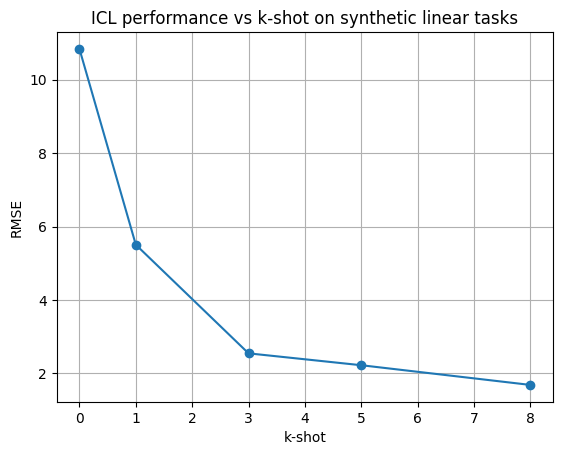

In [12]:
ks = sorted(icl_results.keys())
rmses = [icl_results[k] for k in ks]
plt.figure()
plt.plot(ks, rmses, marker='o')
plt.xlabel('k-shot')
plt.ylabel('RMSE')
plt.title('ICL performance vs k-shot on synthetic linear tasks')
plt.grid(True)
plt.show()

In [13]:
print('\nSample qualitative predictions by k-shot:')
for _ in range(5):
    t = random.choice(test_tasks)
    print('\nTask:')
    print('  xs:', np.round(t.xs, 3))
    print('  ys:', np.round(t.ys, 3))
    print('  x_query:', round(t.xq, 3))
    print('  y_query (true):', round(t.yq, 3))
    for k in [0, 1, 3, 5, 8]:
        K_total = t.xs.shape[0]
        if k > K_total:
            continue
        if k == 0:
            pairs = []
        else:
            idxs = random.sample(range(K_total), k)
            pairs = [(t.xs[i], t.ys[i]) for i in idxs]
        tokens = build_icl_tokens(pairs, t.xq)
        length = torch.tensor([tokens.size(0)], dtype=torch.long).to(device)
        x = tokens.unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            y_pred = model(x, length).item()
        print(f'    k={k}-shot → y_pred={y_pred:.3f}, error={y_pred - t.yq:.3f}')



Sample qualitative predictions by k-shot:

Task:
  xs: [-4.585 -3.779  7.738  2.005  9.368 -6.05 ]
  ys: [-3.412 -5.071  3.494 -0.958  2.841 -6.047]
  x_query: 2.508
  y_query (true): -0.373
    k=0-shot → y_pred=-0.610, error=-0.237
    k=1-shot → y_pred=1.670, error=2.043
    k=3-shot → y_pred=-0.838, error=-0.465
    k=5-shot → y_pred=-0.405, error=-0.032

Task:
  xs: [-7.224  3.161  1.427  3.64  -1.514  9.509 -6.926]
  ys: [-22.604   4.44    0.43    5.522  -7.284  22.075 -22.875]
  x_query: -8.716
  y_query (true): -27.529
    k=0-shot → y_pred=-0.109, error=27.420
    k=1-shot → y_pred=-18.404, error=9.125
    k=3-shot → y_pred=-18.191, error=9.338
    k=5-shot → y_pred=-18.513, error=9.017

Task:
  xs: [-8.756 -8.865  5.851  8.553  2.326]
  ys: [  2.788   4.226  -9.088 -11.923  -5.228]
  x_query: 3.683
  y_query (true): -7.603
    k=0-shot → y_pred=-0.588, error=7.015
    k=1-shot → y_pred=-1.873, error=5.731
    k=3-shot → y_pred=-5.458, error=2.145
    k=5-shot → y_pred=-7.095